In [163]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import matplotlib.animation

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [64]:
batch_size = 128
num_epochs = 100
image_size = 64
num_channels = 3
z_size = 100
num_g_filters = 64
num_d_filters = 64
lr = 0.0002
betas = (0.5, 0.999)
num_workers = 4

In [65]:
dataset = torchvision.datasets.ImageFolder(root = os.path.relpath("dataset/"),
                                          transform=transforms.Compose([
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=(0.4819, 0.4325, 0.3845), std=(0.1503, 0.1454, 0.1465))
                                          ]))

dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=4)

In [23]:
# mean = 0.0
# for images, _ in dataloader:
#     batch_samples = images.size(0) 
#     images = images.view(batch_samples, images.size(1), -1)
#     mean += images.mean(2).sum(0)
# mean = mean / len(dataloader.dataset)

# var = 0.0
# pixel_count = 0
# for images, _ in dataloader:
#     batch_samples = images.size(0)
#     images = images.view(batch_samples, images.size(1), -1)
#     var += ((images - mean.unsqueeze(1))**2).sum([0,2])
#     pixel_count += images.nelement()
# std = torch.sqrt(var / pixel_count)
# mean, std

(tensor([0.4819, 0.4325, 0.3845]), tensor([0.1503, 0.1454, 0.1465]))

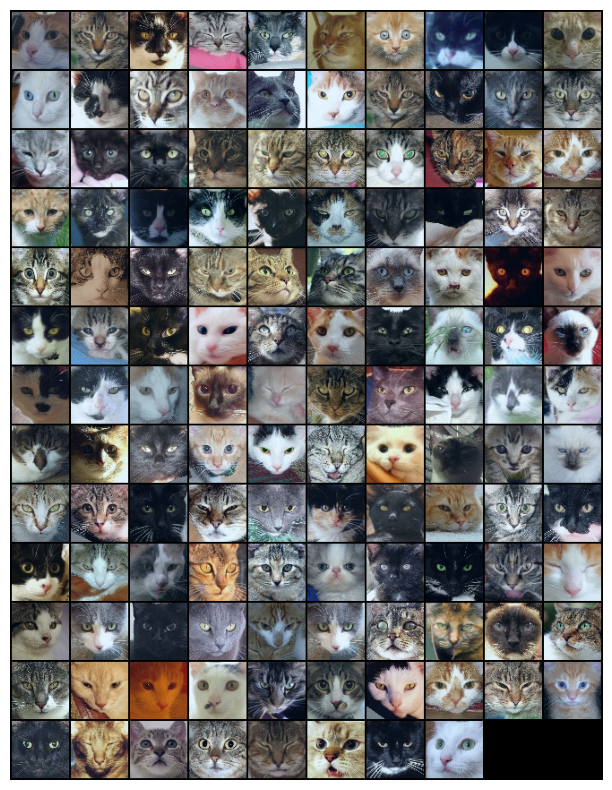

In [66]:
real_batch = next(iter(dataloader))
images, labels = real_batch
grid = torchvision.utils.make_grid(images, nrow=10, normalize=True)

fig, ax = plt.subplots(figsize=(10,10))
ax.axis("off")
ax.imshow(grid.permute(1,2,0))
plt.show()

In [67]:
def initialize_weights(module):
    class_name = module.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(module.weight.data, mean=0.0, std=0.02)

In [68]:
generator = nn.Sequential(nn.ConvTranspose2d(in_channels = z_size, out_channels = num_g_filters * 8, kernel_size=4, stride=1, padding=0, bias=False), 
                         nn.BatchNorm2d(num_features=num_g_filters * 8),
                         nn.ReLU(inplace=True),
                         
                         nn.ConvTranspose2d(in_channels = num_g_filters * 8, out_channels = num_g_filters * 4, kernel_size=4, stride=2, padding=1, bias=False), 
                         nn.BatchNorm2d(num_features=num_g_filters * 4),
                         nn.ReLU(inplace=True),
                          
                         nn.ConvTranspose2d(in_channels = num_g_filters * 4, out_channels = num_g_filters * 2, kernel_size=4, stride=2, padding=1, bias=False), 
                         nn.BatchNorm2d(num_features=num_g_filters * 2),
                         nn.ReLU(inplace=True),
                          
                         nn.ConvTranspose2d(in_channels = num_g_filters * 2, out_channels = num_g_filters, kernel_size=4, stride=2, padding=1, bias=False), 
                         nn.BatchNorm2d(num_features=num_g_filters),
                         nn.ReLU(inplace=True),
                          
                          nn.ConvTranspose2d(in_channels = num_g_filters, out_channels = num_channels, kernel_size = 4, stride=2, padding=1, bias=False),
                          nn.Tanh()
                         )

In [69]:
generator = generator.to(device)
generator.apply(initialize_weights)
generator

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [70]:
discriminator = nn.Sequential( nn.Conv2d(in_channels=num_channels, out_channels=num_d_filters, kernel_size=4, stride=2, padding=1, bias=False),
                              nn.LeakyReLU(negative_slope=0.2, inplace=True),
                              
                              nn.Conv2d(in_channels=num_d_filters, out_channels=num_d_filters * 2, kernel_size=4, stride=2, padding=1, bias=False),
                              nn.BatchNorm2d(num_features=num_d_filters*2),
                              nn.LeakyReLU(negative_slope=0.2, inplace=True),
                              
                              nn.Conv2d(in_channels=num_d_filters * 2, out_channels=num_d_filters * 4, kernel_size=4, stride=2, padding=1, bias=False),
                              nn.BatchNorm2d(num_features=num_d_filters*4),
                              nn.LeakyReLU(negative_slope=0.2, inplace=True),
                              
                              nn.Conv2d(in_channels=num_d_filters * 4, out_channels=num_d_filters * 8, kernel_size=4, stride=2, padding=1, bias=False),
                              nn.BatchNorm2d(num_features=num_d_filters*8),
                              nn.LeakyReLU(negative_slope=0.2, inplace=True),
                              
                              nn.Conv2d(in_channels=num_d_filters * 8, out_channels=num_channels, kernel_size=4, stride=1, padding=0, bias=False),
                              nn.Sigmoid()
                                )

In [71]:
discriminator = discriminator.to(device)
discriminator.apply(initialize_weights)
discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(512, 3, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Sigmoid()
)

In [72]:
g_optim = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
d_optim = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

In [73]:
fake_img_grids = []
g_losses = []
d_losses = []

In [74]:
fixed_noise = torch.randn(size=(64, z_size, 1, 1), device=device)

with torch.no_grad():
    fixed_fakes = generator(fixed_noise).cpu()
fake_img_grids.append(torchvision.utils.make_grid(
    fixed_fakes, padding=2, normalize=True
))

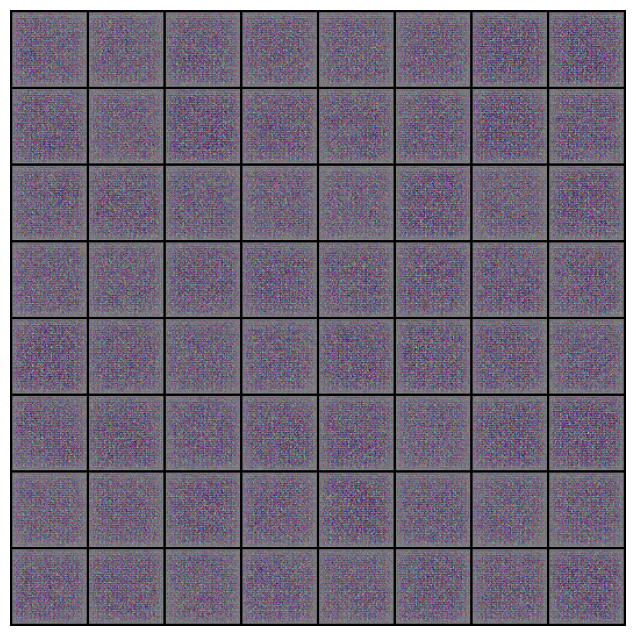

In [75]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(fake_img_grids[0].permute(1,2,0))

In [169]:
bce_loss = nn.BCELoss()

def discriminator_loss(real_output, fake_output):
    real_loss = bce_loss(real_output, torch.ones_like(real_output))
    fake_loss = bce_loss(fake_output, torch.zeros_like(fake_output))
    return real_loss + fake_loss

def generator_loss(fake_output):
    fake_loss = bce_loss(fake_output, torch.ones_like(fake_output))
    return fake_loss

In [170]:
fake_img_grids = []

In [171]:
for epoch in range(num_epochs):
    for batch in dataloader:
        discriminator.zero_grad()
        
        real_images = batch[0].to(device)
        real_output = discriminator(real_images)
        
        noise = torch.randn(real_images.size(0), z_size, 1, 1).to(device)
        fake_images = generator(noise)
        fake_output = discriminator(fake_images.detach())
        
        loss_d = discriminator_loss(real_output, fake_output)
        loss_d.backward()
        d_optim.step()
        
        
        generator.zero_grad()
        fake_output = discriminator(fake_images)
        loss_g = generator_loss(fake_output)
        loss_g.backward()
        g_optim.step()
        
    print(f"Epoch: {epoch} \t Generator Loss: {loss_g:.4f} Discriminator Loss: {loss_d:.4f}")
        
        
    with torch.no_grad():
        fixed_noise = torch.randn(size=(64, z_size, 1, 1), device=device)
        fixed_fakes = generator(fixed_noise).cpu()
    fake_img_grids.append(torchvision.utils.make_grid(fixed_fakes, p1adding=2, normalize=True))

Epoch: 0 	 Generator Loss: 0.2057 Discriminator Loss: 0.6516
Epoch: 1 	 Generator Loss: 4.4714 Discriminator Loss: 0.2920
Epoch: 2 	 Generator Loss: 0.2091 Discriminator Loss: 1.3740
Epoch: 3 	 Generator Loss: 1.4411 Discriminator Loss: 0.5670
Epoch: 4 	 Generator Loss: 2.2370 Discriminator Loss: 0.6193
Epoch: 5 	 Generator Loss: 3.8501 Discriminator Loss: 0.2677
Epoch: 6 	 Generator Loss: 7.6683 Discriminator Loss: 0.0092
Epoch: 7 	 Generator Loss: 6.8833 Discriminator Loss: 0.6934
Epoch: 8 	 Generator Loss: 4.9784 Discriminator Loss: 0.1015
Epoch: 9 	 Generator Loss: 2.2437 Discriminator Loss: 2.1959
Epoch: 10 	 Generator Loss: 15.9303 Discriminator Loss: 0.3467
Epoch: 11 	 Generator Loss: 0.1181 Discriminator Loss: 0.6849
Epoch: 12 	 Generator Loss: 7.0238 Discriminator Loss: 0.0303
Epoch: 13 	 Generator Loss: 6.0757 Discriminator Loss: 0.0082
Epoch: 14 	 Generator Loss: 7.7655 Discriminator Loss: 0.0035
Epoch: 15 	 Generator Loss: 4.5420 Discriminator Loss: 15.5413
Epoch: 16 	 Gene

KeyboardInterrupt: 